In [1]:
using DataFrames
using DataStructures
using CSV
using StatsPlots
using Distributions
using Interpolations
using KernelDensity
include("../../ThinkBayes.jl/src/ThinkBayes.jl")
using .ThinkBayes

In [2]:
df2011 = DataFrame(CSV.File("../../ThinkBayes2/data/showcases.2011.csv"));
df2012 = DataFrame(CSV.File("../../ThinkBayes2/data/showcases.2012.csv"));
df2011 = dropmissing(df2011)
df2012 = dropmissing(df2012)
df2011 = permutedims(df2011, 1)
df2012 = permutedims(df2012, 1)

,Column1,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
,String,String7,String7,String7,String7,String7,String7
1,Sep. 24,40811,62485,22000,40500,18811,21985
2,Sep. 25,31259,32972,10000,21000,21259,11972
3,Sep. 26,41943,24755,39500,22500,2443,2255
4,Sep. 27,24946,34665,21513,32000,3433,2665
5,Sep. 28,26257,48635,23420,35000,2837,13635
6,Oct. 1,49928,42621,36500,34000,13428,8621
7,Oct. 2,30744,22253,26500,18000,4244,4253
8,Oct. 3,37671,24251,42000,26000,-4329,-1749
9,Oct. 4,32255,45871,25000,29000,7255,16871


In [3]:
function stoi(df)
    for name in names(df)[2:end]
        df[!, name] = [parse(Float64, x[1:end]) for x in df[!, name]];
    end
end

stoi (generic function with 1 method)

In [4]:
stoi(df2011)

In [5]:
stoi(df2012)

In [6]:
df = vcat(df2011, df2012)
df = df[:, names(df)[2:end]]
first(df, 3)

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
,Float64,Float64,Float64,Float64,Float64,Float64
1,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
2,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
3,32815.0,53186.0,32000.0,45000.0,815.0,8186.0


In [7]:
maximum(df[:, "Showcase 1"]), maximum(df[:, "Showcase 2"])

(58342.0, 71628.0)

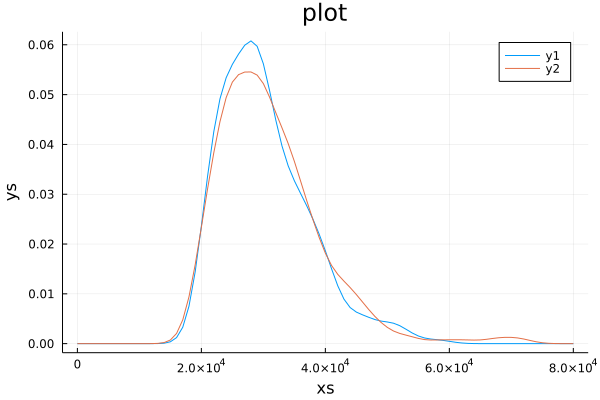

In [8]:
prior1 = kde_from_sample(df[:, "Showcase 1"], 0, 80000, 81)
prior2 = kde_from_sample(df[:, "Showcase 2"], 0, 80000, 81)
plot(prior1)
plot!(prior2)

## Distribution of Error 

In [9]:
sample_diff1 = df[:, "Bid 1"] .- df[:, "Showcase 1"]
sample_diff2 = df[:, "Bid 2"] .- df[:, "Showcase 2"];

In [10]:
kde_diff1 = kde_from_sample(sample_diff1, -40000, 20000, 61)
kde_diff2 = kde_from_sample(sample_diff2, -40000, 20000, 61);

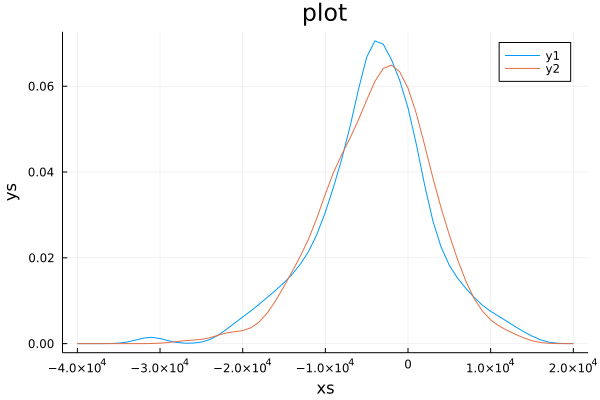

In [11]:
plot(kde_diff1)
plot!(kde_diff2)

In [12]:
mean_diff1 = mean(sample_diff1)
std_diff1 = std(sample_diff1)
mean_diff1, std_diff1

(-4116.3961661341855, 6899.909806377118)

In [13]:
error_dist1 = Normal(0, std_diff1)

Normal{Float64}(μ=0.0, σ=6899.909806377118)

In [14]:
pdf(error_dist1, -100)

5.78124056400869e-5

## Update

In [15]:
guess1 = 23000
error1 = guess1 .- values(prior1);

In [16]:
likelihood = [pdf(error_dist1, x) for x in error1];

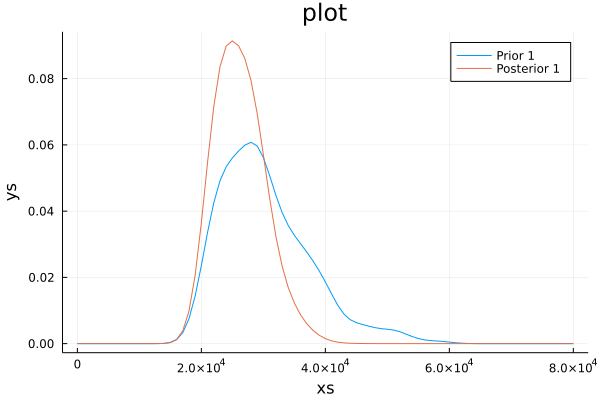

In [17]:
posterior1 = prior1 * likelihood
plot(prior1, label="Prior 1")
plot!(posterior1, label="Posterior 1")

In [18]:
mean(prior1), mean(posterior1)

(30299.4888211387, 26218.949835537245)

_exercise 9.2_

In [19]:
mean_diff2 = mean(sample_diff2)
std_diff2 = std(sample_diff2)
mean_diff2, std_diff2

(-3675.891373801917, 6886.260711323408)

In [20]:
error_dist2 = Normal(0, std_diff2)

Normal{Float64}(μ=0.0, σ=6886.260711323408)

In [21]:
guess2 = 38000
error2 = guess2 .- values(prior2);

In [22]:
likelihood = [pdf(error_dist2, x) for x in error2];

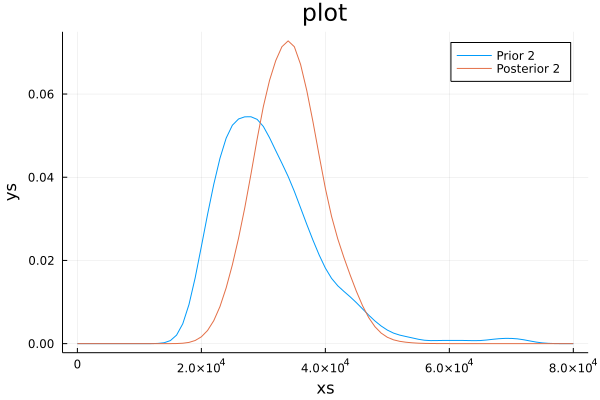

In [23]:
posterior2 = prior2 * likelihood
plot(prior2, label="Prior 2")
plot!(posterior2, label="Posterior 2")

In [24]:
mean(prior2), mean(posterior2)

(31047.678992665347, 34211.254966227556)

## Probability of Winning

In [25]:
prob_overbid(sample_diff) = mean(sample_diff .> 0)

prob_overbid (generic function with 1 method)

In [26]:
prob_worse_than(diff, sample_diff) = mean(sample_diff .< diff)

prob_worse_than (generic function with 1 method)

In [27]:
prob_worse_than(-5000, sample_diff2)

0.38338658146964855

In [28]:
function compute_prob_win(diff, sample_diff)
    if diff > 0
        return 0
    end
    p1 = prob_overbid(sample_diff)
    p2 = prob_worse_than(diff, sample_diff)

    p1 + p2
end

compute_prob_win (generic function with 1 method)

In [29]:
compute_prob_win(-5000, sample_diff2)

0.6741214057507987

In [30]:
xs = LinRange(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff2) for x in xs];

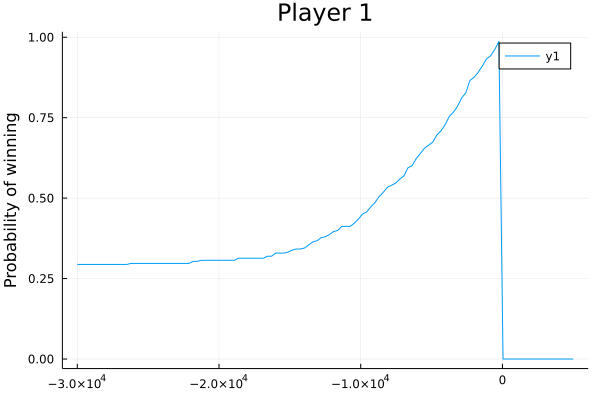

In [31]:
plot(xs, ys, yaxis=("Probability of winning"), plot_title="Player 1")

_exercise 9.3_

In [32]:
prob_overbid(sample_diff1)

0.24600638977635783

In [33]:
prob_worse_than(-5000, sample_diff1)

0.3993610223642173

In [34]:
compute_prob_win(-5000, sample_diff1)

0.6453674121405751

In [35]:
xs = LinRange(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff1) for x in xs];

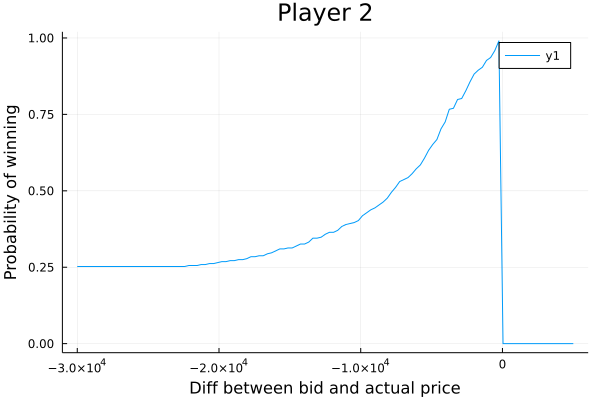

In [36]:
plot(xs, ys, xaxis=("Diff between bid and actual price"), yaxis=("Probability of winning"), plot_title="Player 2")

## Decision Analysis

In [37]:
total_prob_win(bid, posterior, sample_diff) = sum([prob * compute_prob_win(bid - price, sample_diff) for (price,prob) in items(posterior)])

total_prob_win (generic function with 1 method)

In [38]:
total_prob_win(25000, posterior1, sample_diff2)

0.4854885194259129

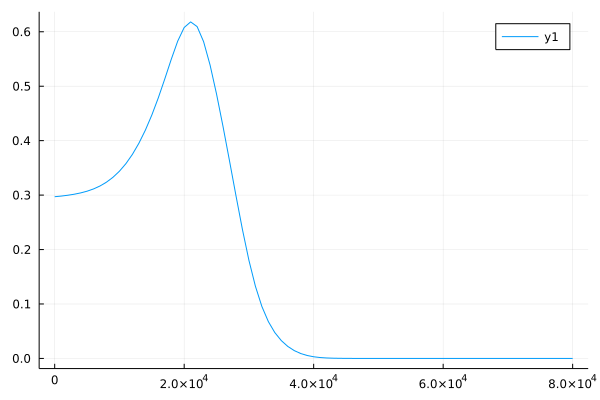

In [39]:
bids = values(posterior1)
probs_win = [total_prob_win(bid, posterior1, sample_diff2) for bid in bids]
plot(bids, probs_win)

In [40]:
(prob, idx) = findmax(probs_win)
bids[idx]

21000.0

In [41]:
prob

0.6181004150794833

_exercise 9.4_

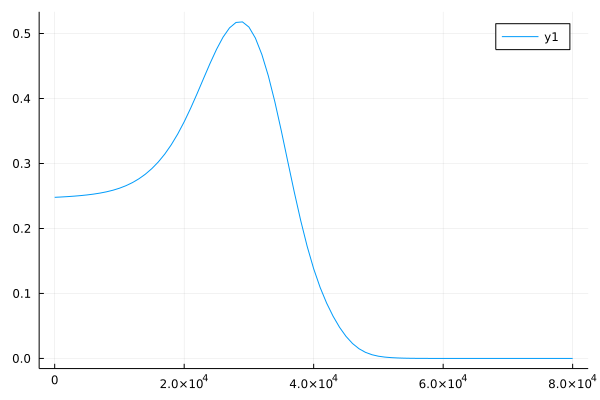

In [42]:
bids_p2 = values(posterior2)
probs_p2 = [total_prob_win(bid, posterior2, sample_diff1) for bid in bids_p2]
plot(bids_p2, probs_p2)

In [43]:
(prob_p2, idx_p2) = findmax(probs_p2)
bids_p2[idx_p2]

29000.0

In [44]:
prob_p2

0.5178869122066051

## Maximizing Expected Gain

In [45]:
function compute_gain(bid, price, sample_diff)
    diff = bid - price
    prob = compute_prob_win(diff, sample_diff)
    if -250 <= diff <= 0
        return 2 * price * prob
    else
        return price * prob 
    end
end

compute_gain (generic function with 1 method)

In [46]:
compute_gain(30000, 35000, sample_diff2)

23594.249201277955

In [47]:
expected_gain(bid, posterior, sample_diff) = sum([prob * compute_gain(bid, price, sample_diff) for (price, prob) in items(posterior)])

expected_gain (generic function with 1 method)

In [48]:
expected_gain(21000, posterior1, sample_diff2)

17036.504705401236

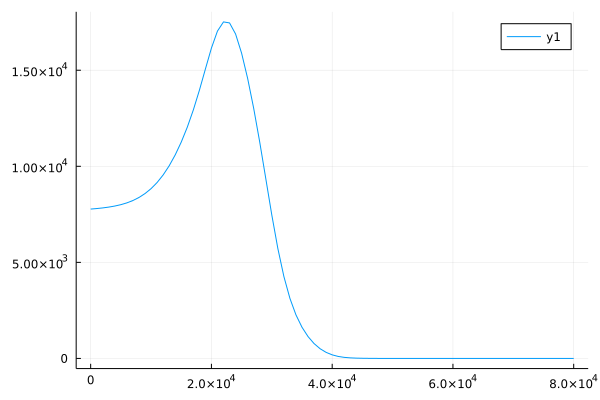

In [49]:
bids = values(posterior1)
gains = [expected_gain(bid, posterior1, sample_diff2) for bid in bids]
plot(bids, gains)

In [50]:
(prob, idx) = findmax(gains)
bids[idx]

22000.0

In [51]:
gains[idx]

17513.43835786043

_exercise 9.5_

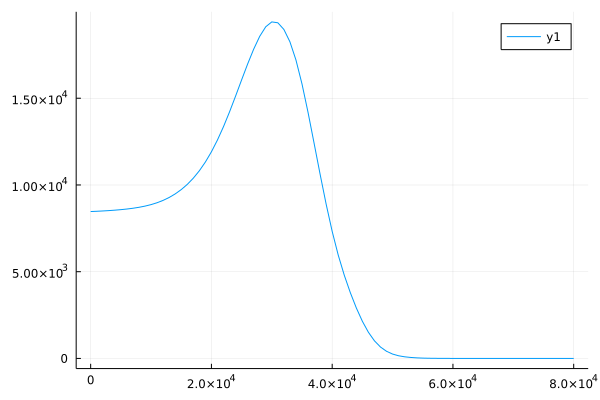

In [52]:
bids_p2 = values(posterior2)
gains_p2 = [expected_gain(bid, posterior2, sample_diff1) for bid in bids_p2]
plot(bids_p2, gains_p2)

In [53]:
(prob_p2, idx_p2) = findmax(gains_p2)
bids_p2[idx_p2]

30000.0

In [54]:
gains_p2[idx_p2]

19401.66219131534

_exercise 9.6_

what we know:
   1. subway is probably a poisson distribution with an average time between trains of around 8 minutes.
   2. Average number of people waiting is 10.
   3. since arrival is random it implies that approximately 10 people arrive in 4 minutes or 2.5 per minute.



In [55]:
observed_gap_times = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
];


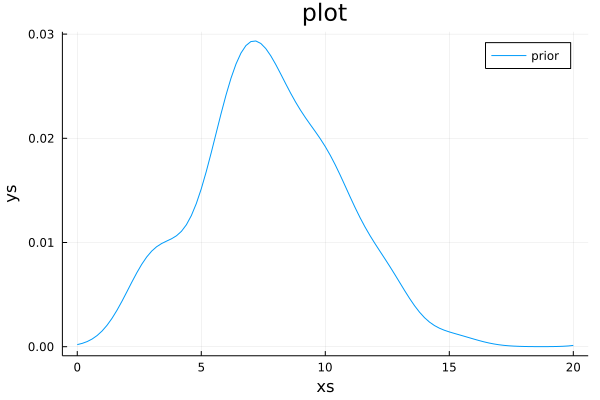

In [56]:
pmf_z = kde_from_sample(observed_gap_times./60, 0, 20, 101)
plot(pmf_z, label="prior")

In [57]:
mean(pmf_z), std(pmf_z)

(7.773669531168934, 2.9214610471125937)

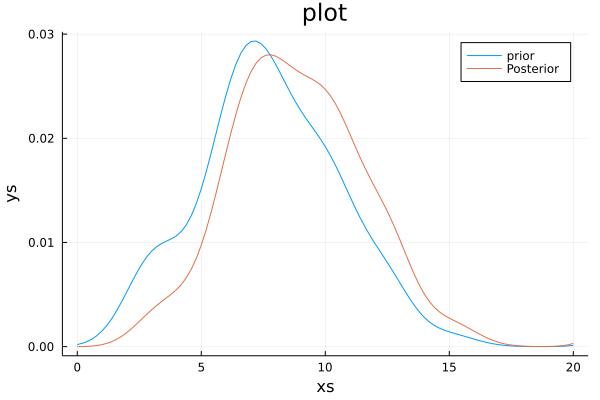

In [58]:
likelihood = values(pmf_z)
posterior_z = pmf_z * likelihood;
plot!(posterior_z, label="Posterior")

In [59]:
qs = values(posterior_z);

In [60]:
make_elapsed_dist(gap, qs) = pmf_from_seq(qs[qs .<= gap])

make_elapsed_dist (generic function with 1 method)

In [61]:
pmf_seq = [make_elapsed_dist(gap, qs) for gap in qs];

In [62]:
pmf_x = make_mixture(posterior_z, pmf_seq);


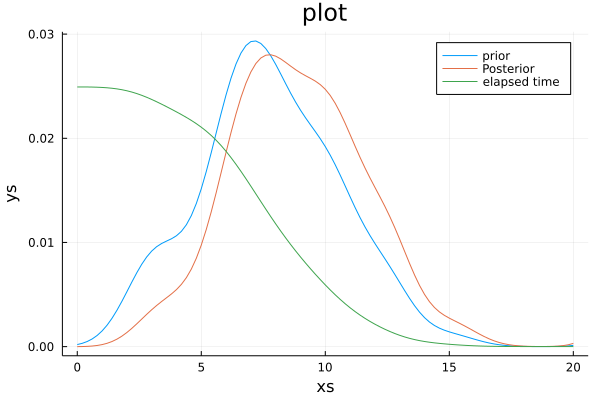

In [63]:
plot!(pmf_x, label="elapsed time")

In [64]:
mean(posterior_z), mean(pmf_x)

(8.87159820122301, 4.435799100611505)

## Counting Passengers

In [65]:
lambda = 2
num_passengers = 10
vals = values(pmf_x)
likelihood = [pdf(Distributions.Poisson(lambda * v), num_passengers) for v in vals];


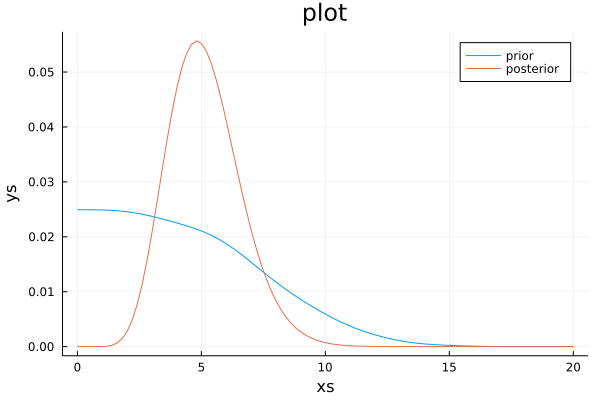

In [66]:
posterior_x = pmf_x * likelihood
plot(pmf_x, label="prior")
plot!(posterior_x, label="posterior")

In [67]:
mean(pmf_x), mean(posterior_x)

(4.435799100611505, 5.1432534463645565)

In [68]:
posterior_y = sub_dist(posterior_z, posterior_x)

201×2 DataFrame
 Row │ Values   Probs       
     │ Float64  Float64     
─────┼──────────────────────
   1 │   -20.0  0.0
   2 │   -19.8  6.42119e-18
   3 │   -19.6  3.36233e-17
   4 │   -19.4  1.09678e-16
   5 │   -19.2  2.84792e-16
   6 │   -19.0  6.42942e-16
   7 │   -18.8  1.31726e-15
   8 │   -18.6  2.5097e-15
  ⋮  │    ⋮          ⋮
 195 │    18.8  2.9435e-8
 196 │    19.0  6.75777e-9
 197 │    19.2  1.036e-9
 198 │    19.4  8.4221e-11
 199 │    19.6  2.14909e-12
 200 │    19.8  3.12878e-15
 201 │    20.0  0.0
            186 rows omitted

In [71]:
pos_y = [(x, y) for (x, y) in items(posterior_y) if x >= 0]
posterior_y = pmf_from_seq([x for (x, y) in pos_y], normalize([y for (x, y) in pos_y]));
mean(posterior_y)

4.379791772318345

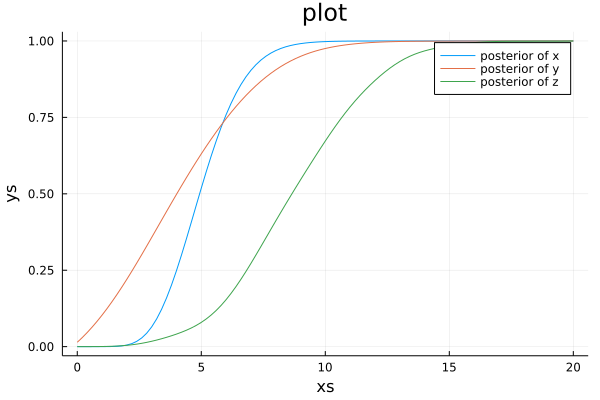

In [74]:
plot(make_cdf(posterior_x), label="posterior of x")
plot!(make_cdf(posterior_y), label="posterior of y")
plot!(make_cdf(posterior_z), label="posterior of z")